# Benchmarks

In [1]:
import os
import sys
sys.path.append(f'{os.getcwd()}/../../')
sys.path.append(f'{os.getcwd()}/analytic')

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

# First

In [2]:
dimension = 1
npoints   = 1000
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

dens = 1.0E+12                 # [m^-3]
abun = 1.0E+10                 # [m^-3]
temp = 4.5E+00                 # [K]
turb = 0.0E+00                 # [m/s]
dx   = 1.0E+04                 # [m]
dv   = 0.0E+00 / magritte.CC   # [fraction of speed of light]

modelFile = 'constant_velocity_gradient_1d.hdf5'
lamdaFile = '../data/test.txt'

model = magritte.Model ()
model.parameters.set_model_name(modelFile)
model.parameters.set_dimension (dimension)
model.parameters.set_npoints   (npoints)
model.parameters.set_nrays     (nrays)
model.parameters.set_nspecs    (nspecs)
model.parameters.set_nlspecs   (nlspecs)
model.parameters.set_nquads    (nquads)

model.geometry.points.position.set([[i*dx, 0, 0] for i in range(npoints)])
model.geometry.points.velocity.set([[i*dv, 0, 0] for i in range(npoints)])

model.chemistry.species.abundance = [[     0.0,   abun,  dens,  0.0,      1.0] for _ in range(npoints)]
model.chemistry.species.symbol    =  ['dummy0', 'test',  'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_LTE_level_populations   ()
model.compute_inverse_line_widths     ()

model.compute_radiation_field         ()

0

In [3]:
eta = np.array(model.lines.emissivity)
chi = np.array(model.lines.opacity)

In [4]:
x  = np.array(model.geometry.points.position)[:,0]
nu = np.array(model.radiation.frequencies.nu)
I  = np.array(model.radiation.I, copy=True)

In [5]:
from tools import LTEpop, profile, lineEmissivity, lineOpacity, lineSource, I_CMB

ld = model.lines.lineProducingSpecies[0].linedata

k = 0

frq = ld.frequency[k]
pop = LTEpop         (ld, temp) * abun
phi = profile        (ld, k, temp, (turb/magritte.CC)**2, frq)
eta = lineEmissivity (ld, pop)[k] * phi
chi = lineOpacity    (ld, pop)[k] * phi
src = lineSource     (ld, pop)[k]
bdy = I_CMB          (frq)

def I_0 (x):
    return src + (bdy-src)*np.exp(-chi*x)

def I_1 (x):
    return src + (bdy-src)*np.exp(-chi*(x[-1]-x))

def relative_error (a,b):
    return 2.0*(a-b)/(a+b)

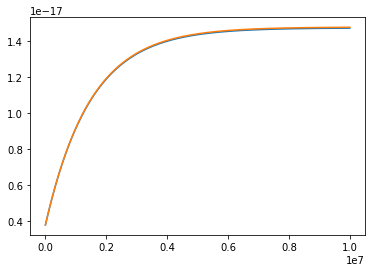

In [6]:
plt.plot(x, I[0,:,0])
plt.plot(x, I_0(x))

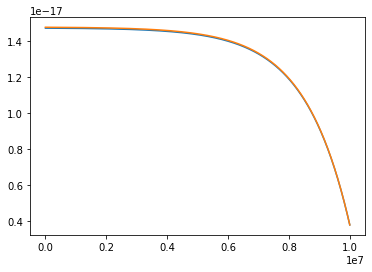

In [7]:
plt.plot(x, I[1,:,0])
plt.plot(x, I_1(x))

In [9]:
error_I_0 = relative_error (I_0(x), I[0,:,0])
error_I_1 = relative_error (I_1(x), I[1,:,0])

In [10]:
np.max(error_I_0)

0.0033759253999904835

In [11]:
np.max(error_I_1)

0.0033759253999904835

# Second

In [6]:
import numpy             as np
import scipy             as sp
import magritte.setup    as setup
import magritte.core     as magritte
import healpy


dimension = 3
nshells   = 20
nrays     = 12*3**2
nspecs    = 5
nlspecs   = 1
nquads    = 15

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
rho_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-8   # [.]
temp   =  20.00   # [K]
turb   = 150.00   # [.]


def rho (r):
    return rho_in * np.power(r_in/r, 2.0)

def abn (r):
    return X_mol * rho(r)


r_shell = np.logspace (np.log10(r_in), np.log10(r_out), nshells, endpoint=True)

npoints_in_shell = [healpy.nside2npix(1+s) for s in range(nshells)]
npoints          = sum(npoints_in_shell)


xyz = np.array([[0, 0, 0]])
for (r, n) in zip(r_shell, npoints_in_shell):
    pos = r*np.array(healpy.pixelfunc.pix2vec(healpy.npix2nside(n), range(n))).T
    pos = sp.spatial.transform.Rotation.random().apply(pos)
    xyz = np.concatenate((xyz, pos))
position = xyz[1:]

rs = np.linalg.norm(position, axis=1)

modelFile = 'vanZadelhoff_1a_1D.hdf5'
lamdaFile = '../data/test.txt'


model = magritte.Model ()
model.parameters.set_model_name(modelFile)
model.parameters.set_dimension (dimension)
model.parameters.set_npoints   (npoints)
model.parameters.set_nrays     (nrays)
model.parameters.set_nspecs    (nspecs)
model.parameters.set_nlspecs   (nlspecs)
model.parameters.set_nquads    (nquads)

model.parameters.set_pop_prec (1.0e-6)

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.chemistry.species.abundance = [[     0.0, abn(r), rho(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)

model.parameters.set_nboundary(npoints_in_shell[-1])
model.geometry.boundary.boundary2point.set(range(npoints-npoints_in_shell[-1], npoints))

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

model.compute_level_populations       (False, 50)

29

In [7]:
pops = np.array(model.lines.lineProducingSpecies[0].population).reshape((model.parameters.npoints(), 2))
abun = np.array(model.chemistry.species.abundance)[:,1]
r    = np.linalg.norm(np.array(model.geometry.points.position), axis=1)

In [8]:
(i,ra,rb,nh,tk,nm,vr,db,td,lp0,lp1) = np.loadtxt ('numeric/vanZadelhoff_1a.out', skiprows=14, unpack=True)

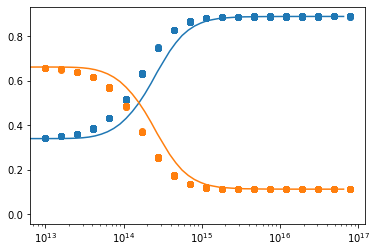

In [12]:
plt.scatter(r, pops[:,0]/abun)
plt.scatter(r, pops[:,1]/abun)

plt.plot(ra, lp0)
plt.plot(ra, lp1)


plt.xscale('log')
# plt.yscale('log')

In [10]:
pops_LTE

NameError: name 'pops_LTE' is not defined

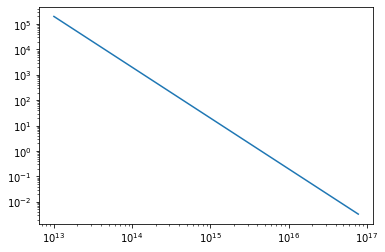

In [39]:
plt.plot(r,abun)
plt.xscale('log')
plt.yscale('log')

In [12]:
ra

array([0.000000e+00, 1.000000e+13, 1.200689e+13, 1.441654e+13,
       1.730978e+13, 2.078366e+13, 2.495471e+13, 2.996284e+13,
       3.597605e+13, 4.319605e+13, 5.186502e+13, 6.227375e+13,
       7.477140e+13, 8.977719e+13, 1.077945e+14, 1.294276e+14,
       1.554023e+14, 1.865899e+14, 2.240364e+14, 2.689980e+14,
       3.229829e+14, 3.878020e+14, 4.656296e+14, 5.590763e+14,
       6.712767e+14, 8.059944e+14, 9.677486e+14, 1.161965e+15,
       1.395159e+15, 1.675151e+15, 2.011336e+15, 2.414988e+15,
       2.899650e+15, 3.481578e+15, 4.180292e+15, 5.019230e+15,
       6.026533e+15, 7.235992e+15, 8.688175e+15, 1.043180e+16,
       1.252534e+16, 1.503904e+16, 1.805721e+16, 2.168109e+16,
       2.603224e+16, 3.125663e+16, 3.752948e+16, 4.506124e+16,
       5.410453e+16, 6.496271e+16])

In [13]:
lp0

array([0.       , 0.3392711, 0.3393228, 0.3394485, 0.3396941, 0.3401967,
       0.3411636, 0.3429922, 0.3460701, 0.3512577, 0.3591426, 0.3699297,
       0.3848794, 0.4045552, 0.4304342, 0.461365 , 0.4976445, 0.5398288,
       0.5871306, 0.6383877, 0.685203 , 0.7314961, 0.7698037, 0.8022523,
       0.826276 , 0.8446579, 0.8579319, 0.8683927, 0.873988 , 0.879094 ,
       0.8813577, 0.8833984, 0.8849738, 0.8860983, 0.8863653, 0.8869822,
       0.8872817, 0.8874472, 0.8875881, 0.8877354, 0.8877727, 0.8878008,
       0.8878277, 0.8878464, 0.8878792, 0.8878819, 0.8878914, 0.8878902,
       0.8878956, 0.887896 ])